In [1]:
import pandas as pd
from transformers import pipeline
from nltk.translate.bleu_score import corpus_bleu
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from math import exp
from tqdm import tqdm 

The original dataset was having 12500 rows so I reduced the size of rows using the following code (you can use the whole train_df if you need better understanding but for the sake of simplicity I am reducing the rows)

In [20]:
train_df1 = pd.read_csv("/kaggle/input/training-dataset/train.csv")
train_df=train_df1.head(150)

In [21]:
models = [
    "facebook/bart-large-cnn",
    "t5-large",
    "sshleifer/distilbart-cnn-12-6",
    "google/pegasus-large",
    "allenai/led-large-16384-arxiv",
]

In [22]:
def semantic_coherence(generated_summary, dialogue):
    summary_tokens = word_tokenize(generated_summary.lower())
    dialogue_tokens = word_tokenize(dialogue.lower())
    common_tokens = set(summary_tokens) & set(dialogue_tokens)
    coherence_score = len(common_tokens) / len(summary_tokens)
    return coherence_score


In [23]:
def factual_accuracy(generated_summary, reference_summary):
    gen_tokens = set(word_tokenize(generated_summary.lower()))
    ref_tokens = set(word_tokenize(reference_summary.lower()))
    common_tokens = gen_tokens & ref_tokens
    accuracy_score = len(common_tokens) / len(ref_tokens) if len(ref_tokens) != 0 else 0
    return accuracy_score


In [24]:
def content_coverage(generated_summary, dialogue):
    summary_tokens = set(word_tokenize(generated_summary.lower()))
    dialogue_tokens = set(word_tokenize(dialogue.lower()))
    common_tokens = summary_tokens & dialogue_tokens
    coverage_score = len(common_tokens) / len(dialogue_tokens) if len(dialogue_tokens) != 0 else 0
    return coverage_score


In [25]:
from math import log
def fluency(generated_summary):
    tokens = word_tokenize(generated_summary.lower())
    token_freq = Counter(tokens)
    total_log_prob = sum(-log(token_freq[token] / len(tokens)) for token in token_freq)
    perplexity = exp(total_log_prob / len(tokens))
    return perplexity

In [28]:
evaluation_results_list = []

In [29]:
for model_name in models:
    print(f"Evaluating model: {model_name}")
    summarizer = pipeline("summarization", model=model_name, tokenizer=model_name)
    semantic_coherence_scores = []
    factual_accuracy_scores = []
    content_coverage_scores = []
    fluency_scores = []
    generated_summaries = []
    for index, row in tqdm(train_df.iterrows(), total=len(train_df)):  # Use tqdm to show progress
        dialogue = row['dialogue']
        summary = row['summary']
        generated_summary = summarizer(dialogue, max_length=150, min_length=30, do_sample=False)[0]["summary_text"]
        generated_summaries.append(generated_summary)
        coherence_score = semantic_coherence(generated_summary, dialogue)
        semantic_coherence_scores.append(coherence_score)
        accuracy_score = factual_accuracy(generated_summary, summary)
        factual_accuracy_scores.append(accuracy_score)
        coverage_score = content_coverage(generated_summary, dialogue)
        content_coverage_scores.append(coverage_score)
        fluency_score = fluency(generated_summary)
        fluency_scores.append(fluency_score)
    evaluation_results_list.append({
        "Model": model_name,
        "Semantic Coherence": sum(semantic_coherence_scores) / len(semantic_coherence_scores),
        "Factual Accuracy": sum(factual_accuracy_scores) / len(factual_accuracy_scores),
        "Content Coverage": sum(content_coverage_scores) / len(content_coverage_scores),
        "Fluency": sum(fluency_scores) / len(fluency_scores)
    })
    print("="*50)

Evaluating model: facebook/bart-large-cnn


100%|██████████| 150/150 [22:15<00:00,  8.91s/it]


Evaluating model: t5-large


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.95G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/models/t5/tokenization_t5_fast.py:160: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-large automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
100%|██████████| 150/150 [50:05<00:00, 20.04s/it]


Evaluating model: sshleifer/distilbart-cnn-12-6


config.json:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

100%|██████████| 150/150 [17:23<00:00,  6.96s/it]


Evaluating model: google/pegasus-large


config.json:   0%|          | 0.00/3.09k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-large and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/260 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

100%|██████████| 150/150 [54:57<00:00, 21.98s/it]


Evaluating model: allenai/led-large-16384-arxiv


config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.84G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/207 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/27.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

100%|██████████| 150/150 [1:19:49<00:00, 31.93s/it]

In [30]:
evaluation_results = pd.concat([pd.DataFrame(item, index=[0]) for item in evaluation_results_list], ignore_index=True)


In [31]:
evaluation_results.to_csv("evaluation_results.csv", index=False)

In [32]:
evaluation_results

,Model,Semantic Coherence,Factual Accuracy,Content Coverage,Fluency
0,facebook/bart-large-cnn,0.655736,0.458349,0.371619,13.824154
1,t5-large,0.755254,0.457265,0.408908,15.828586
2,sshleifer/distilbart-cnn-12-6,0.707827,0.521906,0.484382,15.687915
3,google/pegasus-large,0.706821,0.420956,0.364452,11.779998
4,allenai/led-large-16384-arxiv,0.192766,0.288377,0.190282,4.300495


In [36]:
final_df=pd.read_csv('/kaggle/input/final-result/final_result.csv')

In [37]:
final_df

,Model,Semantic Coherence,Factual Accuracy,Content Coverage,Fluency,Topsis Score,Rank
0,facebook/bart-large-cnn,0.655736,0.458349,0.371619,13.824154,0.248993,3.0
1,t5-large,0.755254,0.457265,0.408908,15.828586,0.148285,4.0
2,sshleifer/distilbart-cnn-12-6,0.707827,0.521906,0.484382,15.687915,0.047022,5.0
3,google/pegasus-large,0.706821,0.420956,0.364452,11.779998,0.309265,2.0
4,allenai/led-large-16384-arxiv,0.192766,0.288377,0.190282,4.300495,1.000000,1.0


In [38]:
import matplotlib.pyplot as plt

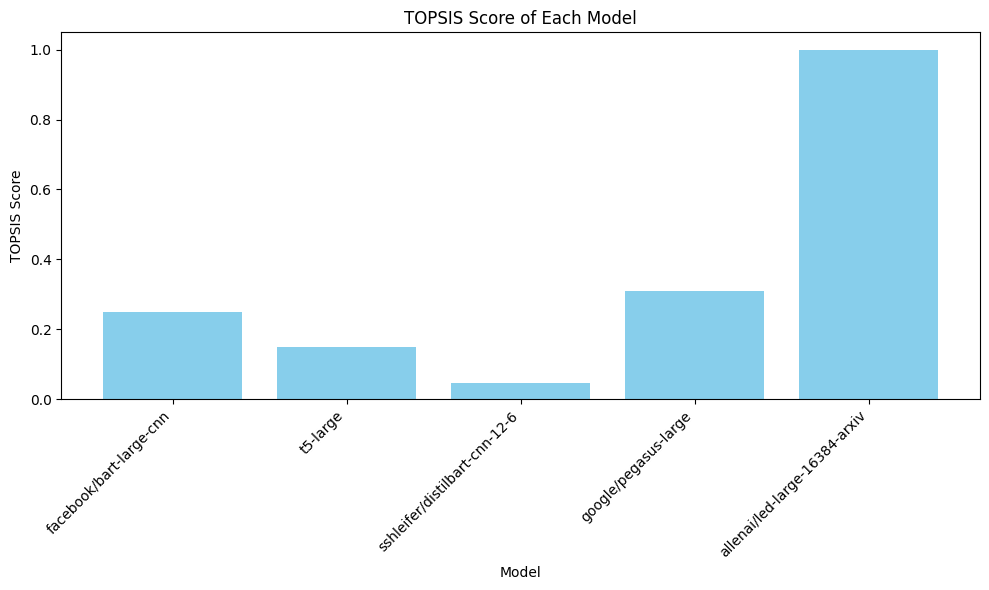

In [39]:
plt.figure(figsize=(10, 6))
plt.bar(final_df["Model"], final_df["Topsis Score"], color='skyblue')
plt.xlabel("Model")
plt.ylabel("TOPSIS Score")
plt.title("TOPSIS Score of Each Model")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()